# Import Libraries and Load Data

### Define Warning Blocker 

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, log_loss, auc
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE

In [4]:
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

### Load Data

In [5]:
df = pd.read_csv("telco_train.csv", index_col=0)
df_test = pd.read_csv("telco_test.csv", index_col=0)

## Feature Selection and Engineering

In [6]:
df.head(10)

,gender,senior,partner,dependents,tenure,phone,multiple_lines,online_security,online_backup,device_protection,...,monthly_charges,total_charges,internet_dsl,internet_fiber,contract_1_yr,contract_2_yr,payment_credit_card,payment_electronic_check,payment_mailed_check,churn
2142,0,0,0,1,21,1,0,1,0,1,...,64.85,1336.80,1,0,1,0,0,0,1,0
1623,0,0,0,0,54,1,1,0,1,0,...,97.20,5129.45,0,1,0,1,0,0,0,0
6074,1,0,1,0,1,0,0,0,0,0,...,23.45,23.45,1,0,0,0,0,1,0,1
1362,1,0,0,0,4,1,0,0,0,0,...,70.20,237.95,0,1,0,0,0,1,0,1
6754,1,0,0,1,0,1,1,1,1,0,...,61.90,0.00,1,0,0,1,0,0,0,0
1212,1,0,0,0,7,1,0,0,0,0,...,69.55,521.35,0,1,0,0,0,1,0,0
2722,1,0,1,1,32,1,0,0,0,0,...,18.95,613.95,0,0,0,1,0,0,1,0
4006,1,0,1,1,72,1,0,0,0,0,...,19.80,1414.65,0,0,0,1,1,0,0,0
6791,1,0,0,0,19,0,0,0,0,1,...,39.65,733.35,1,0,0,0,0,1,0,1
5466,1,0,0,1,10,1,0,0,0,0,...,19.95,219.50,0,0,1,0,0,0,0,0


In [7]:
df.columns

Index(['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'internet_dsl',
       'internet_fiber', 'contract_1_yr', 'contract_2_yr',
       'payment_credit_card', 'payment_electronic_check',
       'payment_mailed_check', 'churn'],
      dtype='object')

In [8]:
# Adding Feature for average charges by tenure
df["average_charges"] = df.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)
df_test["average_charges"] = df_test.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)

# Adding Feature for whether the customer is a single parent
df["single_parent"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)
df_test["single_parent"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)

# Adding Feature for whether the customer is a senior without immediate family
df["lonely_senior"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)
df_test["lonely_senior"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)

# Adding Feature for whether the customer is a repeat renewer (has renewed monthly for over 12 months)
df["repeat_renewer"] = df.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)
df_test["repeat_renewer"] = df_test.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)

# Adding Feature for total count of family members for the customer, using and sharing services
df["total_fam"] = df.apply(lambda x: int(x['partner']) + int(x['dependents']) + 1, axis=1)
df_test["total_fam"] = df_test.apply(lambda x: int(x['partner']) + int(x['dependents']) + 1, axis=1)



### Edit the Datasets to Preprocess

In [9]:
X = df.drop(["churn"], axis=1)
y = df.churn.reset_index().churn

X_test = df_test.drop(["churn"], axis=1)
y_test = df_test.churn.reset_index().churn

In [10]:
X = X.astype(np.float64)
X_test = X_test.astype(np.float64)
Xu = X.values
Xu_test = X_test.values

### Scale the Dataset

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

### Split for Cross Validation

In [12]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


Prior to Running models, we can set a baseline by calculating the null accuracy

In [13]:
print("The Null Accuracy of Churn Prediction: %0.3f" % (1-np.mean(y)))

The Null Accuracy of Churn Prediction: 0.734


## Logistic Regression Models

### Simple Logistic Regression

In [14]:
logreg_basic = LogisticRegression(solver="lbfgs", random_state=0)
logreg_basic.fit(X, y)
print("Accuracy of Logistic Regression on training set: {:.3f}".format(logreg_basic.score(X, y)))

# Cross Validation Error

gen_error_lrb = list()
f1_lrb = list()
ra_lrb = list()

for train_index, test_index in kf.split(X):
    logreg_basic_gen = LogisticRegression(solver="lbfgs", random_state=0)
    logreg_basic_gen.fit(X[train_index], y[train_index])
    gen_error_lrb.append(logreg_basic_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_basic_gen.predict(X[test_index])
    f1_lrb.append(f1_score(y[test_index],y_pred))
    ra_lrb.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross-Validation error is %0.3f" % np.mean(gen_error_lrb))
print("F1 Score is %0.3f" % np.mean(f1_lrb))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrb))


Accuracy of Logistic Regression on training set: 0.803
Cross-Validation error is 0.799
F1 Score is 0.571
ROC-AUC Score is 0.706


### Ridge Logistic Regression

In [15]:
logreg_ridge = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2")
logreg_ridge.fit(X, y)
print("Accuracy of Ridge Logistic Regression on training set: {:.2f}".format(logreg_ridge.score(X, y)))




# Estimating Ridge Parameter

best_c_ridge = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_ridge=c

print("Best Ridge Regression Parameter is: %0.2f" % best_c_ridge)




# Cross Validation Error

gen_error_lrr = list()
f1_lrr = list()
ra_lrr = list()

for train_index, test_index in kf.split(X):
    logreg_ridge_gen = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=best_c_ridge)
    logreg_ridge_gen.fit(X[train_index], y[train_index])
    gen_error_lrr.append(logreg_ridge_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_ridge_gen.predict(X[test_index])
    f1_lrr.append(f1_score(y[test_index],y_pred))
    ra_lrr.append(roc_auc_score(y[test_index],y_pred))

print("Cross-Validation error is %0.3f" % np.mean(gen_error_lrr))
print("F1 Score is %0.3f" % np.mean(f1_lrr))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrr))


Accuracy of Ridge Logistic Regression on training set: 0.80
Best Ridge Regression Parameter is: 0.08
Cross-Validation error is 0.801
F1 Score is 0.573
ROC-AUC Score is 0.707


### Lasso Logistic Regression

In [16]:
logreg_lasso = LogisticRegression(solver='saga', random_state=0, penalty="l1")
logreg_lasso.fit(X, y)
print("Accuracy of Lasso Logistic Regression on training set: {:.2f}".format(logreg_lasso.score(X, y)))



# Estimating Lasso Parameter

best_c_lasso = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="saga", random_state=0, penalty="l1", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_lasso=c

print("Best Lasso Regression Parameter is: %0.2f" % best_c_lasso)



# Cross Validation Error

gen_error_lrl = list()
f1_lrl = list()
ra_lrl = list()

for train_index, test_index in kf.split(X):
    logreg_lasso_gen = LogisticRegression(solver="saga", random_state=0, penalty="l2", C=best_c_lasso)
    logreg_lasso_gen.fit(X[train_index], y[train_index])
    gen_error_lrl.append(logreg_lasso_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_lasso_gen.predict(X[test_index])
    f1_lrl.append(f1_score(y[test_index],y_pred))
    ra_lrl.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross-Validation error is %0.3f" % np.mean(gen_error_lrl))
print("F1 Score is %0.3f" % np.mean(f1_lrl))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrl))

Accuracy of Lasso Logistic Regression on training set: 0.80
Best Ridge Regression Parameter is: 0.07
Cross-Validation error is 0.801
F1 Score is 0.572
ROC-AUC Score is 0.707


## Discriminant analyses

### LDA  

In [17]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
print("Accuracy of LDA on training set: {:.2f}".format(lda.score(X, y)))



# Cross Validation Error

gen_error_lda = list()
f1_lda = list()
ra_lda = list()


for train_index, test_index in kf.split(X):
    lda_gen = LinearDiscriminantAnalysis()
    lda_gen.fit(X[train_index], y[train_index])
    gen_error_lda.append(lda_gen.score(X[test_index], y[test_index]))
    y_pred = lda_gen.predict(X[test_index])
    f1_lda.append(f1_score(y[test_index],y_pred))
    ra_lda.append(roc_auc_score(y[test_index],y_pred))

print("Cross Validation Error on LDA: ",np.mean(gen_error_lda))
print("F1 score on LDA: ",np.mean(f1_lda))
print("ROC-AUC Score on LDA: ",np.mean(ra_lda))

Accuracy of LDA on training set: 0.80
Cross Validation Error on LDA:  0.7988958593149669
F1 score on LDA:  0.5710837633952383
ROC-AUC Score on LDA:  0.7060737173292818


#### QDA

In [18]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)
print("Accuracy of QDA on traning set: {:.2f}".format(qda.score(X, y)))

# Cross Validation Error

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis()
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

Accuracy of QDA on traning set: 0.74
Cross Validation Error on QDA:  0.7273666906012624
F1 Score on QDA:  0.6052680690279306
ROC-AUC Score on QDA:  0.7477866698745134


Calculation of the regularizaion parameter of QDA to optimize it for our problem

In [19]:
# Estimating QDA regularization Parameter

best_c_qda = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = QuadraticDiscriminantAnalysis(reg_param=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_qda=c

print("Best regularization parameter for QDA: %0.2f" % best_c_qda)

# Cross Validation Error

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

Best regularization parameter for QDA: 0.81
Cross Validation Error on QDA:  0.7738675157149515
F1 Score on QDA:  0.6031140044398728
ROC-AUC Score on QDA:  0.7342575950730985


## Decision Tree

In [20]:
dtc = tree.DecisionTreeClassifier().fit(X, y)

print("Accuracy of Decision Tree classifier on training set: {:.2f}".format(dtc.score(X, y)))



# Cross Validation Error
gen_error_dt = list()

for train_index, test_index in kf.split(X):
    dt_gen = tree.DecisionTreeClassifier()
    dt_gen.fit(X[train_index], y[train_index])
    gen_error_dt.append(dt_gen.score(X[test_index], y[test_index]))
    
print("Cross Validation Error on Decision Tree: ",np.mean(gen_error_dt))

Accuracy of Decision Tree classifier on training set: 1.00
Cross Validation Error on Decision Tree:  0.7220453371628686


## K-Nearest Neighbors

In [21]:
knn = KNeighborsClassifier().fit(X, y)

print("Accuracy of KNN classifier on training set: {:.2f}".format(knn.score(X, y)))



# Cross Validation Error
gen_error_knn = list()
f1_knn = list()
ra_knn = list()


for train_index, test_index in kf.split(X):
    knn_gen = KNeighborsClassifier()
    knn_gen.fit(X[train_index], y[train_index])
    gen_error_knn.append(knn_gen.score(X[test_index], y[test_index]))
    y_pred = knn_gen.predict(X[test_index])
    f1_knn.append(f1_score(y[test_index],y_pred))
    ra_knn.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on K Nearest Neighbour: ",np.mean(gen_error_knn))
print("F1 Score on K Nearest Neighbour: ",np.mean(f1_knn))
print("ROC-AUC Score on K Nearest Neighbour: ",np.mean(ra_knn))


Accuracy of KNN classifier on training set: 0.83
Cross Validation Error on K Nearest Neighbour:  0.7536333345930489
F1 Score on K Nearest Neighbour:  0.5193314995324623
ROC-AUC Score on K Nearest Neighbour:  0.6738763822146923


## Gaussian Naive Bayes

In [22]:
gnb = GaussianNB().fit(X, y)

print("Accuracy of GNB classifier on training set: {:.2f}".format(gnb.score(X, y)))


# Cross Validation Error

gen_error_gnb = list()
f1_gnb = list()
ra_gnb = list()

for train_index, test_index in kf.split(X):
    gnb_gen = GaussianNB()
    gnb_gen.fit(X[train_index], y[train_index])
    gen_error_gnb.append(gnb_gen.score(X[test_index], y[test_index]))
    y_pred = gnb_gen.predict(X[test_index])
    f1_gnb.append(f1_score(y[test_index],y_pred))
    ra_gnb.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("F1 Score on Gaussian Naive Bayes: ",np.mean(f1_gnb))
print("ROC-AUC Score on Gaussian Naive Bayes: ",np.mean(ra_gnb))


Accuracy of GNB classifier on training set: 0.75
Cross Validation Error on Gaussian Naive Bayes:  0.7479567413677992
F1 Score on Gaussian Naive Bayes:  0.5964259759775136
ROC-AUC Score on Gaussian Naive Bayes:  0.734051159422828


## Support Vector Machine

In [23]:
svm = SVC().fit(X, y)

print("Accuracy of SVM classifier on training set: {:.2f}".format(svm.score(X, y)))



# Cross Validation Error

gen_error_svm = list()
f1_svm = list()
ra_svm = list()


for train_index, test_index in kf.split(X):
    svm_gen = SVC()
    svm_gen.fit(X[train_index], y[train_index])
    gen_error_svm.append(svm_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_svm.append(f1_score(y[test_index],y_pred))
    ra_svm.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on Support Vector Machine: ",np.mean(gen_error_svm))
print("F1 Score on Support Vector Machine: ",np.mean(f1_svm))
print("ROC-AUC Score on Support Vector Machine: ",np.mean(ra_svm))

Accuracy of SVM classifier on training set: 0.82
Cross Validation Error on Support Vector Machine:  0.7949932605217742
F1 Score on Support Vector Machine:  0.544760232353444
ROC-AUC Score on Support Vector Machine:  0.6897575170256924


## Random Forests

In [24]:
rfc = RandomForestClassifier()
rfc.fit(X, y)

print("Accuracy of Random Forests classifier on training set: {:.2f}".format(rfc.score(X, y)))


# Cross Validation Error
gen_error_rf = list()
f1_rf = list()
ra_rf = list()


for train_index, test_index in kf.split(X):
    rf_gen = RandomForestClassifier()
    rf_gen.fit(X[train_index], y[train_index])
    gen_error_rf.append(rf_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_rf.append(f1_score(y[test_index],y_pred))
    ra_rf.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Error on Random Forests: ",np.mean(gen_error_rf))
print("F1 Score on Random Forests: ",np.mean(f1_rf))
print("ROC AUC Score on Random Forests: ",np.mean(ra_rf))

Accuracy of Random Forests classifier on training set: 0.98
Cross Validation Error on Random Forests:  0.7791976871622388
F1 Score on Random Forests:  0.5949697597339095
ROC AUC Score on Random Forests:  0.7190032968126114


## AdaBoost

In [25]:

ada = AdaBoostClassifier()
ada.fit(X, y)

print("Accuracy of AdaBoost classifier on training set: {:.2f}".format(ada.score(X, y)))



# Cross Validation Error

gen_error_ab = list()

for train_index, test_index in kf.split(X):
    ab_gen = AdaBoostClassifier()
    ab_gen.fit(X[train_index], y[train_index])
    gen_error_ab.append(ab_gen.score(X[test_index], y[test_index]))
    
print("Cross Validation Error on AdaBoost: ",np.mean(gen_error_ab))

Accuracy of AdaBoost classifier on training set: 0.81
Cross Validation Error on AdaBoost:  0.7972991698474484


## Neural Net

In [26]:


mlp = MLPClassifier(alpha=1)
mlp.fit(X, y)

print("Accuracy of MLP classifier on training set: {:.2f}".format(mlp.score(X, y)))


# Cross Validation Error

gen_error_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=1)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    
print("Cross Validation Error on NN: %0.3f" % np.mean(gen_error_nn))

Accuracy of MLP classifier on training set: 0.81
Cross Validation Error on NN: 0.794


### Tuning Hyperparameter of Neural Net to Maximise Generalized Score

In [27]:
# Estimating Hyper-Parameter

best_alpha = 0
best_score = 0

for i in range(1,6):
    c = (i/5)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = MLPClassifier(alpha=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_alpha=c

print("Best Parameter for MLP: %0.3f" % best_alpha)


Best Parameter for MLP: 0.800


In [28]:
# Generalized Error

gen_error_nn = list()
f1_nn = list()
ra_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=best_alpha)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    y_pred = nn_gen.predict(X[test_index])
    f1_nn.append(f1_score(y[test_index],y_pred))
    ra_nn.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on MLP with tuned Hyperparameter: ",np.mean(gen_error_nn))
print("F1 Score on MLP with tuned Hyperparameter: ",np.mean(f1_nn))
print("ROC-AUC Score on MLP with tuned Hyperparameter: ",np.mean(ra_nn))

Generalized Error on MLP with tuned Hyperparameter:  0.7937470869077762
F1 Score on MLP with tuned Hyperparameter:  0.5557166353963079
ROC-AUC Score on MLP with tuned Hyperparameter:  0.6963462091320454


# Compare Model Performances

### Cross Validation Error

In [29]:
print("Logistic Regression: ",np.mean(gen_error_lrb))
print("Ridge Regression: ",np.mean(gen_error_lrr))
print("Lasso Regression: ",np.mean(gen_error_lrl))
print("LDA: ",np.mean(gen_error_lda))
print("QDA: ",np.mean(gen_error_qda))
print("Decision Tree: ",np.mean(gen_error_dt))
print("K Nearest Neighbour: ",np.mean(gen_error_knn))
print("Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("SVM: ",np.mean(gen_error_svm))
print("Random Forests: ",np.mean(gen_error_rf))
print("MLP: ",np.mean(gen_error_nn))

Logistic Regression:  0.7994290339241401
Ridge Regression:  0.8012030283561972
Lasso Regression:  0.8010254084627692
LDA:  0.7988958593149669
QDA:  0.7738675157149515
Decision Tree:  0.7220453371628686
K Nearest Neighbour:  0.7536333345930489
Gaussian Naive Bayes:  0.7479567413677992
SVM:  0.7949932605217742
Random Forests:  0.7791976871622388
MLP:  0.7937470869077762


### F1 Score

In [30]:
print("Logistic Regression: %0.3f" % np.mean(f1_lrb))
print("Ridge Regression: %0.3f" % np.mean(f1_lrr))
print("Lasso Regression: %0.3f" % np.mean(f1_lrl))
print("LDA: %0.3f" % np.mean(f1_lda))
print("QDA: %0.3f" % np.mean(f1_qda))
print("K Nearest Neighbour: %0.3f" % np.mean(f1_knn))
print("Gaussian Naive Bayes: %0.3f" % np.mean(f1_gnb))
print("SVM: %0.3f" % np.mean(f1_svm))
print("Random Forests: %0.3f" % np.mean(f1_rf))
print("MLP: %0.3f" % np.mean(f1_nn))

Logistic Regression: 0.571
Ridge Regression: 0.573
Lasso Regression: 0.572
LDA: 0.571
QDA: 0.603
K Nearest Neighbour: 0.519
Gaussian Naive Bayes: 0.596
SVM: 0.545
Random Forests: 0.595
MLP: 0.556


### ROC AUC Score

In [31]:
print("Logistic Regression: %0.3f" % np.mean(ra_lrb))
print("Ridge Regression: %0.3f" % np.mean(ra_lrr))
print("Lasso Regression: %0.3f" % np.mean(ra_lrl))
print("LDA: %0.3f" % np.mean(ra_lda))
print("QDA: %0.3f" % np.mean(ra_qda))
print("K Nearest Neighbour: %0.3f" % np.mean(ra_knn))
print("Gaussian Naive Bayes: %0.3f" % np.mean(ra_gnb))
print("SVM: %0.3f" % np.mean(ra_svm))
print("Random Forests: %0.3f" % np.mean(ra_rf))
print("MLP: %0.3f" % np.mean(ra_nn))


Logistic Regression: 0.706
Ridge Regression: 0.707
Lasso Regression: 0.707
LDA: 0.706
QDA: 0.734
K Nearest Neighbour: 0.674
Gaussian Naive Bayes: 0.734
SVM: 0.690
Random Forests: 0.719
MLP: 0.696


### Tabulated View

In [32]:
models_list = ["Logistic Regression","Ridge Regression","Lasso Regression","Linear Discriminant Analysis",
               "Quadratic Discriminant Analysis","K Nearest Neighbour","Gaussian Naive Bayes",
               "Support Vector Machine","Random Forests","Multi Level Perceptron"]
class_errors = [np.mean(gen_error_lrb),np.mean(gen_error_lrr),np.mean(gen_error_lrl),np.mean(gen_error_lda),
                np.mean(gen_error_qda),np.mean(gen_error_knn),np.mean(gen_error_gnb),np.mean(gen_error_svm),
                np.mean(gen_error_rf),np.mean(gen_error_nn)]
f1_scores_list = [np.mean(f1_lrb),np.mean(f1_lrr),np.mean(f1_lrl),np.mean(f1_lda),np.mean(f1_qda),np.mean(f1_knn),
                  np.mean(f1_gnb),np.mean(f1_svm),np.mean(f1_rf),np.mean(f1_nn)]
ra_scores_list = [np.mean(ra_lrb),np.mean(ra_lrr),np.mean(ra_lrl),np.mean(ra_lda),np.mean(ra_qda),np.mean(ra_knn),
                  np.mean(ra_gnb),np.mean(ra_svm),np.mean(ra_rf),np.mean(ra_nn)]


In [33]:
model_comparison = pd.DataFrame()
model_comparison["Models"] = np.array(models_list)
model_comparison["Classification_Error"] = np.array(class_errors)
model_comparison["F1_Score"] = np.array(f1_scores_list)
model_comparison["ROC_AUC_Score"] = np.array(ra_scores_list)

model_comparison['Classification_Error'] = model_comparison.apply(lambda x: round(x['Classification_Error'],3),axis=1)
model_comparison['F1_Score'] = model_comparison.apply(lambda x: round(x['F1_Score'],3),axis=1)
model_comparison['ROC_AUC_Score'] = model_comparison.apply(lambda x: round(x['ROC_AUC_Score'],3),axis=1)

model_comparison.head(100)

,Models,Classification_Error,F1_Score,ROC_AUC_Score
0,Logistic Regression,0.799,0.571,0.706
1,Ridge Regression,0.801,0.573,0.707
2,Lasso Regression,0.801,0.572,0.707
3,Linear Discriminant Analysis,0.799,0.571,0.706
4,Quadratic Discriminant Analysis,0.774,0.603,0.734
5,K Nearest Neighbour,0.754,0.519,0.674
6,Gaussian Naive Bayes,0.748,0.596,0.734
7,Support Vector Machine,0.795,0.545,0.690
8,Random Forests,0.779,0.595,0.719
9,Multi Level Perceptron,0.794,0.556,0.696


## Plotting ROC for QDA

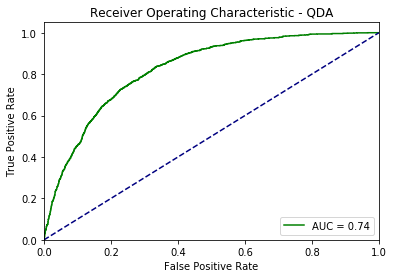

In [34]:
from sklearn.metrics import roc_curve, auc

qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)

qda_gen.fit(X,y)

y_pred = qda_gen.predict_proba(X)
y_pred_actual = qda_gen.predict(X)

res = roc_curve(y,y_pred[:,1], drop_intermediate=False)
roc_auc = roc_auc_score(y,y_pred_actual)

plt.figure()
plt.plot(res[0], res[1], color='green',
        label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - QDA')
plt.legend(loc="lower right")
plt.show()



## ROC AUC for Ridge and LASSO

In [35]:
ridge_gen = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C= best_c_ridge)
lasso_gen = LogisticRegression(solver="saga", random_state=0, penalty="l1", C= best_c_lasso)

ridge_gen.fit(X,y)
lasso_gen.fit(X,y)

y_pred_r = ridge_gen.predict_proba(X)
y_pred_actual_r = ridge_gen.predict(X)
y_pred_l = lasso_gen.predict_proba(X)
y_pred_actual_l = lasso_gen.predict(X)


res_r = roc_curve(y,y_pred_r[:,1], drop_intermediate=False)
roc_auc_r = roc_auc_score(y,y_pred_actual_r)

res_l = roc_curve(y,y_pred_l[:,1], drop_intermediate=False)
roc_auc_l = roc_auc_score(y,y_pred_actual_l)


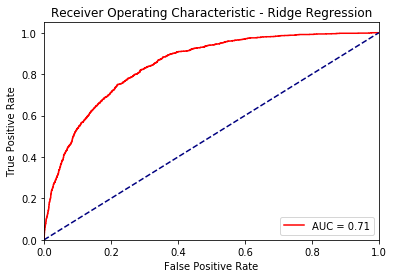

In [36]:
plt.figure()
plt.plot(res_r[0], res_r[1], color='red',
        label = 'AUC = %0.2f' % roc_auc_r)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Ridge Regression')
plt.legend(loc="lower right")
plt.show()

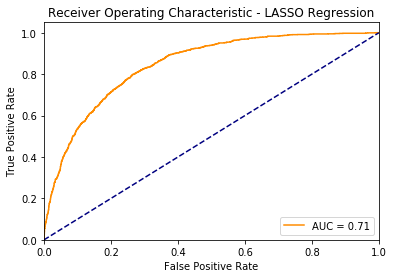

In [37]:
plt.figure()
plt.plot(res_l[0], res_l[1], color='darkorange',
        label = 'AUC = %0.2f' % roc_auc_l)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LASSO Regression')
plt.legend(loc="lower right")
plt.show()

In the model comparison section, the combination of the three factors was taken and the best model was seen to be Quadratic Discriminant Analysis

# Applying QDA Model to Test Data

In [38]:
qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)
qda_gen.fit(X, y)
qda_test_error_score = qda_gen.score(X_test, y_test)
y_pred = qda_gen.predict(X_test)
qda_test_f1_score = f1_score(y_test,y_pred)
qda_test_auc_score = roc_auc_score(y_test,y_pred)
    
print("Test Error on QDA: %0.3f" % qda_test_error_score)
print("Test F1 Score on QDA: %0.3f" % qda_test_f1_score)
print("Test ROC-AUC Score on QDA: %0.3f" % np.mean(ra_qda))

Test Error on QDA: 0.799
Test F1 Score on QDA: 0.653
Test ROC-AUC Score on QDA: 0.734


With a strong F1 Score and ROC area under curve score, the QDA performance has been benchmarked as the best prediction model currently available